<a href="https://colab.research.google.com/github/juanmed/detectron2_instance_segmentation_demo/blob/master/Detectron2_custom_coco_data_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [How to train Detectron2 with Custom COCO Datasets](https://www.dlology.com/blog/how-to-train-detectron2-with-custom-coco-datasets/) | DLology

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

This notebook will help you get started with this framwork by training a instance segmentation model with your custom COCO datasets.

# Install detectron2

In [1]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

Requirement already up-to-date: torch in /usr/local/lib/python3.7/dist-packages (1.8.0+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.7/dist-packages (0.9.0+cu101)
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-fn0t0ng4
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-fn0t0ng4
     |████████████████████████████████| 645kB 7.8MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.4-cp37-none-any.whl size=64349 sha256=13347d8b6c5018bef2cc74adb68c947c594c7e1408f5e45a781d0f806cb70284
  Stored in directory: /tmp/pip-ephem-wheel-cache-x78_zim0/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
Successfully built fvcore
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


'1.8.0+cu101'

In [2]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 11273 (delta 2), reused 5 (delta 1), pack-reused 11259
Receiving objects: 100% (11273/11273), 4.50 MiB | 24.64 MiB/s, done.
Resolving deltas: 100% (8217/8217), done.
Obtaining file:///content/detectron2_repo
     |████████████████████████████████| 2.2MB 8.5MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 
     |████████████████████████████████| 112kB 42.7MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-cp37-none-any.whl size=141231 sha256=b9137a3b1d1beeeec3d95fd67618e1ce1e1b0609bc68285f19dcbeebe64662ff
  Stored in directory: /root/.cache/pip/wheels/e3/e2/fa/b78480b448b8579ddf393bebd3f47ee23aa84c89b6a78285c8
Successfully built antlr4-python3-runtime
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompati

In [1]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Train on a custom COCO dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the fruits nuts segmentation dataset](https://github.com/Tony607/mmdetection_instance_segmentation_demo)
which only has 3 classes: data, fig, and hazelnut.
We'll train a segmentation model from an existing model pre-trained on the COCO dataset, available in detectron2's model zoo.

Note that the COCO dataset does not have the "data", "fig" and "hazelnut" categories.

In [2]:
!pip install gdown

In [3]:
import gdown
import shutil
#https://drive.google.com/file/d/14ZcrZ9JbU8_XvCkGvq00xrZt2hioZjGv/view?usp=sharing
url = 'https://drive.google.com/uc?id=14ZcrZ9JbU8_XvCkGvq00xrZt2hioZjGv'
output = 'data.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=14ZcrZ9JbU8_XvCkGvq00xrZt2hioZjGv
To: /content/data.zip
1.38GB [00:12, 111MB/s] 


'data.zip'

In [4]:
!unzip data.zip > /dev/null

In [5]:
# Download test set
#https://drive.google.com/file/d/1IZpWoEfXUndLCVs0KWVnJxJuH0klxKUY/view?usp=sharing
url = 'https://drive.google.com/uc?id=1IZpWoEfXUndLCVs0KWVnJxJuH0klxKUY'
output = 'test.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1IZpWoEfXUndLCVs0KWVnJxJuH0klxKUY
To: /content/test.zip
213MB [00:03, 55.0MB/s]


'test.zip'

In [6]:
!unzip test.zip > /dev/null

Register the fruits_nuts dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [7]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("skku_unloading_coco_train", {}, "./skku_unloading_coco_train/trainval.json", "./skku_unloading_coco_train/images")

In [8]:
fruits_nuts_metadata = MetadataCatalog.get("skku_unloading_coco_train")
dataset_dicts = DatasetCatalog.get("skku_unloading_coco_train")

[03/23 04:04:32 d2.data.datasets.coco]: Loaded 334 images in COCO format from ./skku_unloading_coco_train/trainval.json


In [9]:
register_coco_instances("skku_unloading_coco_test", {}, "./skku_unloading_coco_test/trainval.json", "./skku_unloading_coco_test/images")
skku_test_metadata = MetadataCatalog.get("skku_unloading_coco_test")
skku_test_dataset_dicts = DatasetCatalog.get("skku_unloading_coco_test")

[03/23 04:04:32 d2.data.datasets.coco]: Loaded 52 images in COCO format from ./skku_unloading_coco_test/trainval.json


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



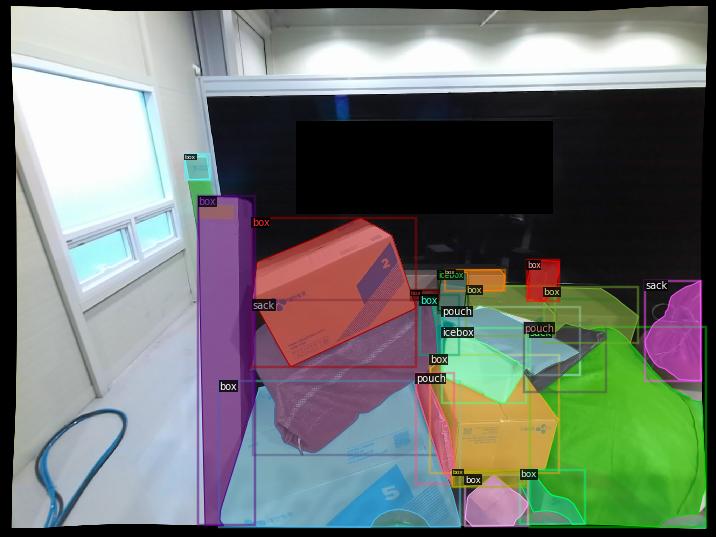

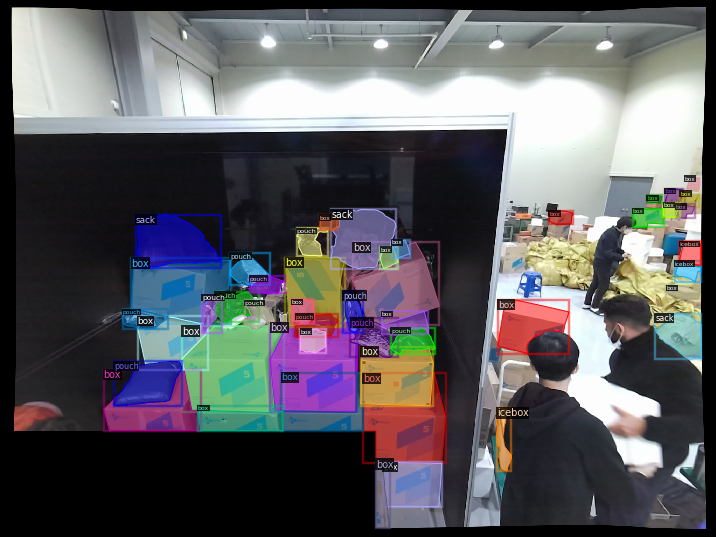

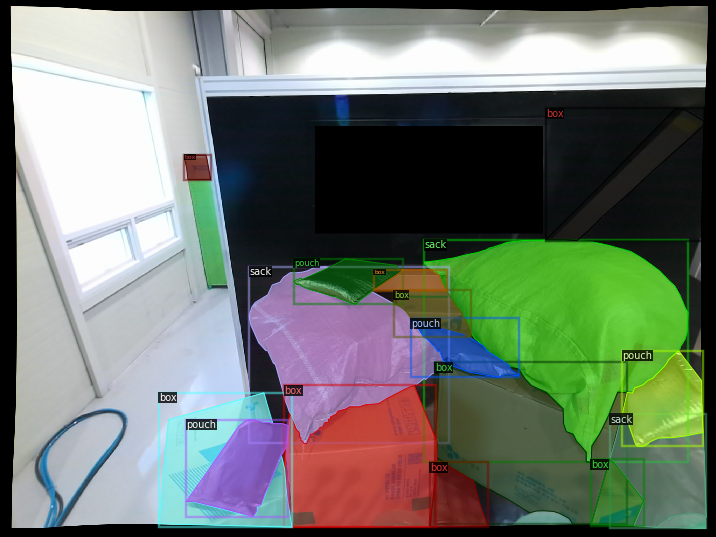

In [10]:
import random

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=fruits_nuts_metadata, scale=0.35)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the fruits_nuts dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU.


In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("skku_unloading_coco_train",)
cfg.DATASETS.TEST = ("skku_unloading_coco_test",)   # no metrics implemented for this dataset
cfg.TEST.EVAL_PERIOD = 100
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = 1500   # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # 3 classes (data, fig, hazelnut)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

Now, we perform inference with the trained model on the fruits_nuts dataset. First, let's create a predictor using the model we just trained:



In [12]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("skku_unloading_coco_test", )
predictor = DefaultPredictor(cfg)

Do evaluation

In [33]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("skku_unloading_coco_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "skku_unloading_coco_test")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

WARNING [03/23 04:49:59 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[03/23 04:49:59 d2.data.datasets.coco]: Loaded 52 images in COCO format from ./skku_unloading_coco_test/trainval.json
[03/23 04:49:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/23 04:49:59 d2.data.common]: Serializing 52 elements to byte tensors and concatenating them all ...
[03/23 04:49:59 d2.data.common]: Serialized dataset takes 0.32 MiB
[03/23 04:49:59 d2.evaluation.evaluator]: Start inference on 52 images
[03/23 04:50:17 d2.evaluation.evaluator]: Inference done 11/52. 0.2022 s / img. ETA=0:01:05
[03/23 04:50:22 d2.evaluation.evaluator]: Inference done 14/52. 0.2066 s / img. ETA=0:01:02
[03/23 04:50:28 d2.evaluation.evaluator]: Inference done 18/52. 0.2017 s / img. ETA=0:00:54
[03/23 04:50:35

Then, we randomly select several samples to visualize the prediction results.

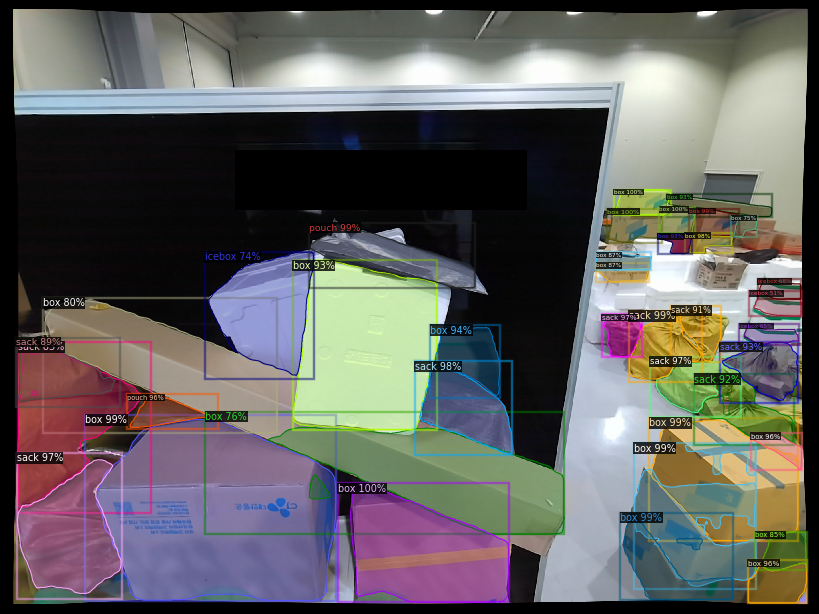

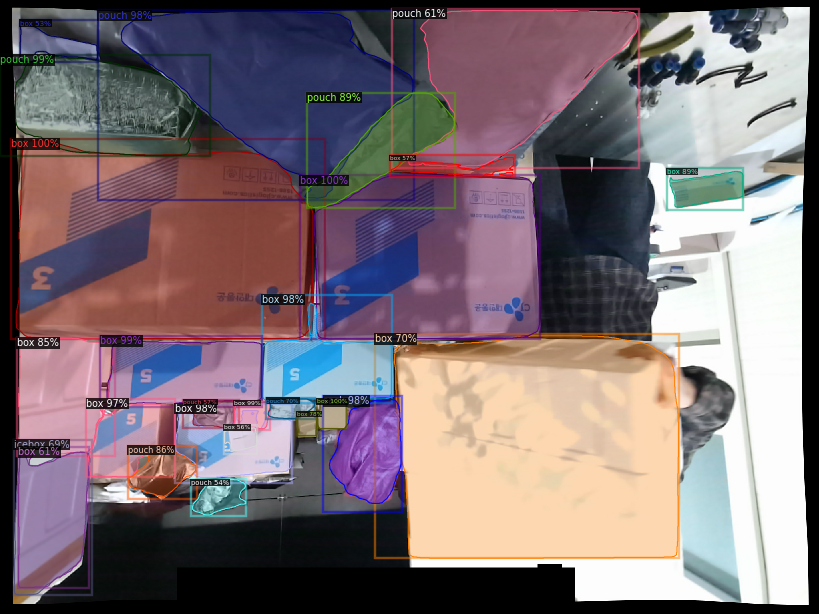

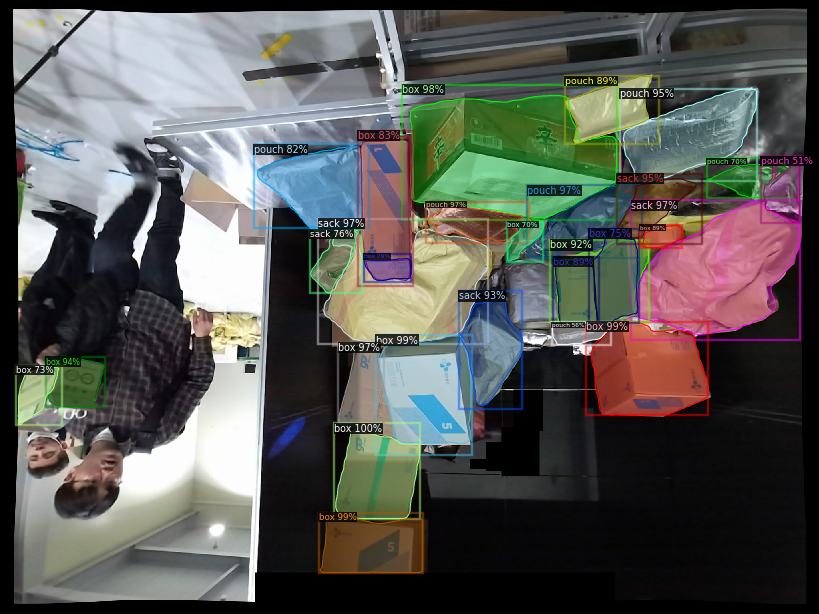

In [13]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(skku_test_dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=skku_test_metadata, 
                   scale=0.4, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [14]:
fruits_nuts_metadata

Metadata(evaluator_type='coco', image_root='./skku_unloading_coco_train/images', json_file='./skku_unloading_coco_train/trainval.json', name='skku_unloading_coco_train', thing_classes=['sack', 'pouch', 'box', 'icebox'], thing_dataset_id_to_contiguous_id={1: 0, 2: 1, 3: 2, 4: 3})

## Benchmark inference speed

In [23]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.15,fps:6.83


# Evaluate performance using pyCOCOtools

In [16]:
!pip install pycocotools

In [17]:
from pycocotools.coco import COCO 
from pycocotools.cocoeval import COCOeval 
import numpy as np 
import skimage.io as io 
import pylab,json 
from tempfile import NamedTemporaryFile

In [63]:
def xyxy2xywh(bbox):
        """Convert ``xyxy`` style bounding boxes to ``xywh`` style for COCO
        evaluation.

        Args:
            bbox (numpy.ndarray): The bounding boxes, shape (4, ), in
                ``xyxy`` order.

        Returns:
            list[float]: The converted bounding boxes, in ``xywh`` order.
        """

        _bbox = bbox.tolist()
        return [
            _bbox[0],
            _bbox[1],
            _bbox[2] - _bbox[0],
            _bbox[3] - _bbox[1],
        ] 

import numpy as np                                 # (pip install numpy)
from skimage import measure                        # (pip install scikit-image)
from shapely.geometry import Polygon, MultiPolygon # (pip install Shapely)

def create_sub_mask_annotation(sub_mask, image_id, category_id, annotation_id, is_crowd, bbox):
    # Find contours (boundary lines) around each sub-mask
    # Note: there could be multiple contours if the object
    # is partially occluded. (E.g. an elephant behind a tree)
    contours = measure.find_contours(sub_mask, 0.5, positive_orientation='low')

    segmentations = []
    polygons = []
    #print(len(contours))
    for contour in contours:
        # Flip from (row, col) representation to (x, y)
        # and subtract the padding pixel
        for i in range(len(contour)):
            row, col = contour[i]
            contour[i] = (col - 1, row - 1)

        # Make a polygon and simplify it
        poly = Polygon(contour)
        poly = poly.simplify(1.0, preserve_topology=False)
        polygons.append(poly)
        segmentation = np.array(poly.exterior.coords).ravel().tolist()
        segmentations.append(segmentation)

    # Combine the polygons to calculate the bounding box and area
    multi_poly = MultiPolygon(polygons)
    #x, y, max_x, max_y = multi_poly.bounds
    #width = max_x - x
    #height = max_y - y
    #bbox = (x, y, width, height)
    area = multi_poly.area

    annotation = {
        'segmentation': segmentations,
        'iscrowd': is_crowd,
        'image_id': image_id,
        'category_id': category_id,
        'id': annotation_id,
        'bbox': bbox,
        'area': area
    }

    return segmentations

In [64]:
# format all outputs into a list of dicts compatible with COCO

import pycocotools.mask as mask_util

#instances = outputs['instances']
#instances.pred_masks_rle = [mask_util.encode(np.asfortranarray(mask)) for mask in instances.pred_masks]
#for rle in instances.pred_masks_rle:
#    rle['counts'] = rle['counts'].decode('utf-8')
#instances.remove('pred_masks')

# TO TEST INVERT CONVERSION
#instances.pred_masks = np.stack([mask_util.decode(rle) for rle in instances.pred_masks_rle])

#Inspired from
# https://www.immersivelimit.com/create-coco-annotations-from-scratch

detection_res = []
is_crowd = 0
for k, d in enumerate(skku_test_dataset_dicts):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    outputs = outputs["instances"].to("cpu")

    bboxes = outputs.pred_boxes
    scores = outputs.scores
    classes = outputs.pred_classes
    masks = outputs.pred_masks
 
    print("Image: ",k,"has {} masks".format(masks.shape[0]))

    #for i,(bbox, score, class_) in enumerate(zip(bboxes, scores, classes)):
    #  #print(i,bbox.tolist(), score.item(), class_.item(), d["image_id"])
    #  annotations = []
    #  for j, mask in enumerate(masks):
    #    #category_id = category_ids[image_id][color]
    #    annotation = create_sub_mask_annotation(mask, d["image_id"], class_, j, is_crowd, xyxy2xywh(bbox))
    #    annotations.append(annotation)
    #  #annotation_id += 1
    #  #image_id += 1


    for i,(bbox, score, class_, mask) in enumerate(zip(bboxes, scores, classes, masks)):

      annotation = create_sub_mask_annotation(mask, d["image_id"], class_, j, is_crowd, xyxy2xywh(bbox))
      #annotations.append(annotation)

      detection_res.append({
          'score': score.item(),
          'category_id': class_.item(),
          'bbox': xyxy2xywh(bbox),
          'image_id': d["image_id"],
          'segmentation': annotation
      })

Image:  0 has 34 masks
Image:  1 has 34 masks
Image:  2 has 17 masks
Image:  3 has 27 masks
Image:  4 has 31 masks
Image:  5 has 57 masks
Image:  6 has 21 masks
Image:  7 has 44 masks
Image:  8 has 43 masks
Image:  9 has 25 masks
Image:  10 has 52 masks
Image:  11 has 43 masks
Image:  12 has 38 masks
Image:  13 has 38 masks
Image:  14 has 28 masks
Image:  15 has 20 masks
Image:  16 has 46 masks
Image:  17 has 22 masks
Image:  18 has 27 masks
Image:  19 has 32 masks
Image:  20 has 20 masks
Image:  21 has 43 masks
Image:  22 has 32 masks
Image:  23 has 46 masks
Image:  24 has 31 masks
Image:  25 has 35 masks
Image:  26 has 24 masks
Image:  27 has 20 masks
Image:  28 has 29 masks
Image:  29 has 21 masks
Image:  30 has 19 masks
Image:  31 has 32 masks
Image:  32 has 26 masks
Image:  33 has 42 masks
Image:  34 has 40 masks
Image:  35 has 20 masks
Image:  36 has 29 masks
Image:  37 has 26 masks
Image:  38 has 19 masks
Image:  39 has 29 masks
Image:  40 has 46 masks
Image:  41 has 22 masks
Im

In [61]:
print(detection_res)

[{'score': 0.9982335567474365, 'category_id': 2, 'bbox': [1601.9659423828125, 757.45947265625, 93.4725341796875, 52.61004638671875], 'image_id': 7, 'annotations': [[1691.0, 808.5, 1693.5, 806.0, 1693.5, 782.0, 1692.5, 765.0, 1689.0, 760.5, 1675.0, 757.5, 1632.0, 756.5, 1609.0, 757.5, 1606.5, 759.0, 1604.5, 763.0, 1601.5, 795.0, 1601.5, 803.0, 1605.0, 806.5, 1621.0, 808.5, 1691.0, 808.5]]}, {'score': 0.9979298114776611, 'category_id': 2, 'bbox': [1630.052001953125, 1024.7369384765625, 351.61669921875, 262.4697265625], 'image_id': 7, 'annotations': [[1882.0, 1285.5, 1897.0, 1283.5, 1910.0, 1277.5, 1916.0, 1276.5, 1949.0, 1259.5, 1970.0, 1257.5, 1974.0, 1256.5, 1977.5, 1253.0, 1979.5, 1245.0, 1980.5, 1214.0, 1980.5, 1112.0, 1979.5, 1102.0, 1976.0, 1096.5, 1966.0, 1091.5, 1941.0, 1086.5, 1930.0, 1080.5, 1913.0, 1077.5, 1899.0, 1070.5, 1885.0, 1069.5, 1871.0, 1062.5, 1836.0, 1058.5, 1822.0, 1053.5, 1807.0, 1051.5, 1798.0, 1048.5, 1776.0, 1046.5, 1727.0, 1037.5, 1698.0, 1036.5, 1686.0, 1039.

In [69]:
# json file in coco format, original annotation data
anno_file = '/content/skku_unloading_coco_test/trainval.json'
coco_gt = COCO(anno_file)
 
 # Use GT box as prediction box for calculation, the purpose is to get detection_res

"""
detection_res = []
with open(anno_file, 'r') as f:
    json_file = json.load(f)
annotations = json_file['annotations']
detection_res = []
for i, anno in enumerate(annotations):
    detection_res.append({
        'score': 1,
        'category_id': anno['category_id'],
        'bbox': anno['bbox'],
        'image_id': anno['image_id']
    })
    if i < 1 :
      print( anno['category_id'], anno['image_id'])
"""
 
with NamedTemporaryFile(suffix='.json') as tf:
         # Due to subsequent needs, first convert detection_res to binary and then write it to the json file
    content = json.dumps(detection_res).encode(encoding='utf-8')
    tf.write(content)
    res_path = tf.name
 
         # loadRes will generate a new COCO type instance based on coco_gt and return
    coco_dt = coco_gt.loadRes(res_path)
 
    cocoEval = COCOeval(coco_gt, coco_dt, 'segm')  # use 'bbox' for bbox mAP or 'segm' for instance segmentation mAP
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()
 
print(cocoEval.stats)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.25s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.98s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.137
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.195
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.159
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.117
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.169
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.011
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.094
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [68]:
#mAP
mean_ap = cocoEval.stats[0].item()  # stats[0] records AP@[0.5:0.95]
print("mAP: ", mean_ap)

mAP:  0.12348297420706852


In [49]:
print(coco_gt.getAnnIds())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 700, 7